# Pipeline for High-z Radio Galaxies 04: Redshift prediction on radio AGN

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done with AGN from the Million Quasar Catalog (MQC) and QSO from SDSS DR16.  
Only sources with confirmed $z$ will be used.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
import cmasher as cmr
from pycaret import regression as pyr
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

Methods to create values of metrics by redshift ranges

In [4]:
def z_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output  = np.zeros_like(z_range)
    true_vals      = metricArgs[0]
    predicted_vals = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        metric_output[count] = metric_function(sub_set.loc[:, true_vals], sub_set.loc[:, predicted_vals])
    return metric_output

Method to plot metrics

In [5]:
def plot_metric_over_z(z_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(z_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ##
    ax_pre.set_xlabel('$z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq z)$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title, fontsize=14)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

***

## Reading data

In [6]:
save_plot_flag  = False
save_model_flag = False
read_idx_flag   = True
load_model_flag = True
use_calibration = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [7]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 
                      'TYPE', 'Sint_LOFAR', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [8]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [9]:
full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'LOFAR_detect'].astype(int)

In [10]:
# full_catalog_df.describe()

#### Select only confirmed radio AGN

In [11]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, {n_is_gal:,} have been indentified as galaxies,' +\
      f' and {n_is_rad:,} are identified as radio detections (in LOFAR).')

In this dataset, with 15,136,878 elements,
50,538 of them are marked as AGN, 68,196 have been indentified as galaxies, and 187,573 are identified as radio detections (in LOFAR).


In [12]:
target_feat = 'Z'

---

Combine redshift values (AGN + galaxies).

In [13]:
idx_non_Z                = full_catalog_df.loc[:, target_feat].where(full_catalog_df.loc[:, target_feat] > 0).isna()
full_catalog_df.loc[idx_non_Z, target_feat] = full_catalog_df.loc[:, target_feat].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

---

## Possible correlations

In [14]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'spCl', 'band_num', 'LOFAR_detect', 'Sint_LOFAR_AB', 'Speak_LOFAR', 'rms_LOFAR', 'Sint_LOFAR_non_imp', 'Sint_LOFAR_AB_non_imp', 'Speak_LOFAR_non_imp', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


remove unnecessary features

In [15]:
full_catalog_df = full_catalog_df.drop(columns=['Sint_LOFAR_AB', 'Speak_LOFAR', 'rms_LOFAR', 
                                                'Sint_LOFAR_non_imp', 'Sint_LOFAR_AB_non_imp', 'Speak_LOFAR_non_imp'])

---

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`is_AGN == 1` and `radio_detect == 1`).

In [16]:
filter_known_spec  = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
filter_known_radio = full_catalog_df.loc[:, 'LOFAR_detect'] == 1
full_catalog_df    = full_catalog_df.loc[filter_known_spec]
if not read_idx_flag:
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   'is_AGN', use_calibration=use_calibration)

if read_idx_flag:
    known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt')
    train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt')
    train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt')  # in the future, fix naming
    validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt')  # in the future, fix naming
    calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt')
    test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt')
    
    train_test_df  = full_catalog_df.loc[train_validation_idx]
    train_df       = full_catalog_df.loc[train_idx]
    test_df        = full_catalog_df.loc[validation_idx]
    calibration_df = full_catalog_df.loc[calibration_idx]
    validation_df  = full_catalog_df.loc[test_idx]
    
print('Shape of used data in HETDEX')
print('-' * 65)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 65)
print()

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (118734, 88)
Data for Modeling (Train, Test, and Calibration): (94987, 88)
Training data:                                    (75989, 88)
Testing data:                                     (9499, 88)
Calibration data:                                 (9499, 88)
Validation data:                                  (23747, 88)
-----------------------------------------------------------------



In [17]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) & (full_catalog_df.loc[:, 'LOFAR_detect'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'is_AGN'] == 1) & (train_test_df.loc[:, 'LOFAR_detect'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'is_AGN'] == 1) & (train_df.loc[:, 'LOFAR_detect'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'is_AGN'] == 1) & (test_df.loc[:, 'LOFAR_detect'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'is_AGN'] == 1) & (calibration_df.loc[:, 'LOFAR_detect'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'is_AGN'] == 1) & (validation_df.loc[:, 'LOFAR_detect'] == 1)]

In [18]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed LOFAR radio detection.')

In this dataset (HETDEX), with 6,419 elements,
6,419 of them are marked as AGN, and, from them, 6,419 have confirmed LOFAR radio detection.


Remove intermediate targets

In [19]:
cols_discard_class = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'LOFAR_detect', 'zsp']
full_catalog_df    = full_catalog_df.drop(columns=cols_discard_class)
train_test_df      = train_test_df.drop(columns=cols_discard_class)
train_df           = train_df.drop(columns=cols_discard_class)
test_df            = test_df.drop(columns=cols_discard_class)
calibration_df     = calibration_df.drop(columns=cols_discard_class)
validation_df      = validation_df.drop(columns=cols_discard_class)

---

In [20]:
print('Final shape of used data')
print('-' * 50)
print('Confirmed Radio AGN')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
Confirmed Radio AGN
--------------------------------------------------
Full confirmed dataset size:        (6419, 80)
Data for Modeling (Train and Test): (5121, 80)
Training data:                      (4091, 80)
Testing data:                       (521, 80)
Calibration data:                   (509, 80)
Validation data:                    (1298, 80)
--------------------------------------------------


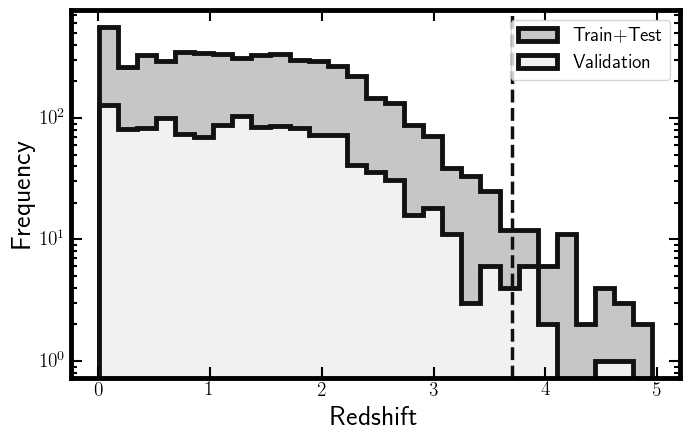

In [21]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, target_feat])
max_score  = np.nanmax(full_catalog_df.loc[:, target_feat])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=3.7, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [22]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [23]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [24]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [25]:
rsd_vals

z_y         297.287339
i_z         232.431467
K_W3        203.140554
i_y         156.587233
r_i         135.063469
W1_W2       123.973906
g_r         111.912079
r_z         106.650081
r_y         105.155357
g_i          95.162011
g_z          86.317055
g_y          86.028088
H_W3         71.428535
Z            66.817398
y_W1         63.647654
J_W3         58.048591
z_W1         57.967523
r_W1         54.684686
i_W1         54.559048
g_W1         53.875796
y_W2         53.814458
y_J          52.484261
z_W2         48.161938
z_J          47.849711
y_H          46.976063
i_J          46.264869
i_W2         45.364613
r_W2         44.291325
r_J          43.768349
g_W2         43.207659
z_H          43.145003
i_H          42.030383
g_J          41.218619
W2_W3        40.839751
W1_W3        40.811788
r_H          40.206583
y_K          40.140589
g_H          38.362951
z_K          37.298441
i_K          36.659803
r_K          35.144506
H_K          34.149532
g_K          33.609874
J_H        

In [26]:
correlation = norm_train_test_df.corr()

In [27]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [28]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [29]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [30]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [31]:
list_drop_corr

['g_H',
 'r_H',
 'J_W1',
 'i_H',
 'y_H',
 'J_W2',
 'z_H',
 'J_W3',
 'Jmag',
 'J_W4',
 'g_K',
 'r_K',
 'i_K',
 'y_K',
 'H_W1',
 'z_K',
 'H_W2',
 'zmag',
 'Kmag',
 'imag',
 'W2mproPM',
 'K_W1',
 'z_W4',
 'r_W4',
 'H_W3',
 'rmag',
 'i_J',
 'W2_W4',
 'g_W2',
 'J_K',
 'z_W3',
 'W1mproPM',
 'gmag',
 'r_W3',
 'g_J',
 'ymag',
 'g_W4',
 'i_W4',
 'W1_W4',
 'i_W1',
 'r_J',
 'g_W1',
 'z_J',
 'H_W4',
 'y_W4',
 'r_W2',
 'W1_W3',
 'i_W2',
 'i_W3',
 'r_W1',
 'g_z',
 'y_W2',
 'z_W2',
 'W3mag',
 'Hmag',
 'g_y',
 'g_i',
 'z_W1',
 'K_W2',
 'r_y',
 'W3_W4',
 'y_W3']

In [32]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [33]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [34]:
corr_discard = norm_train_test_discard.corr()

In [35]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
K_W4      K_W3        0.726245
band_num  y_J         0.720833
K_W3      W4mag       0.715644
z_y       i_y         0.704852
r_z       r_i         0.661700
y_J       W2_W3       0.621571
K_W4      W4mag       0.619690
band_num  H_K         0.605594
i_z       r_z         0.595871
K_W3      y_J         0.568365
Z         W2_W3       0.562478
H_K       W1_W2       0.542407
g_W3      y_J         0.526448
K_W3      band_num    0.523528
dtype: float64

Text(1052.0930609538775, 0.5, 'feature')

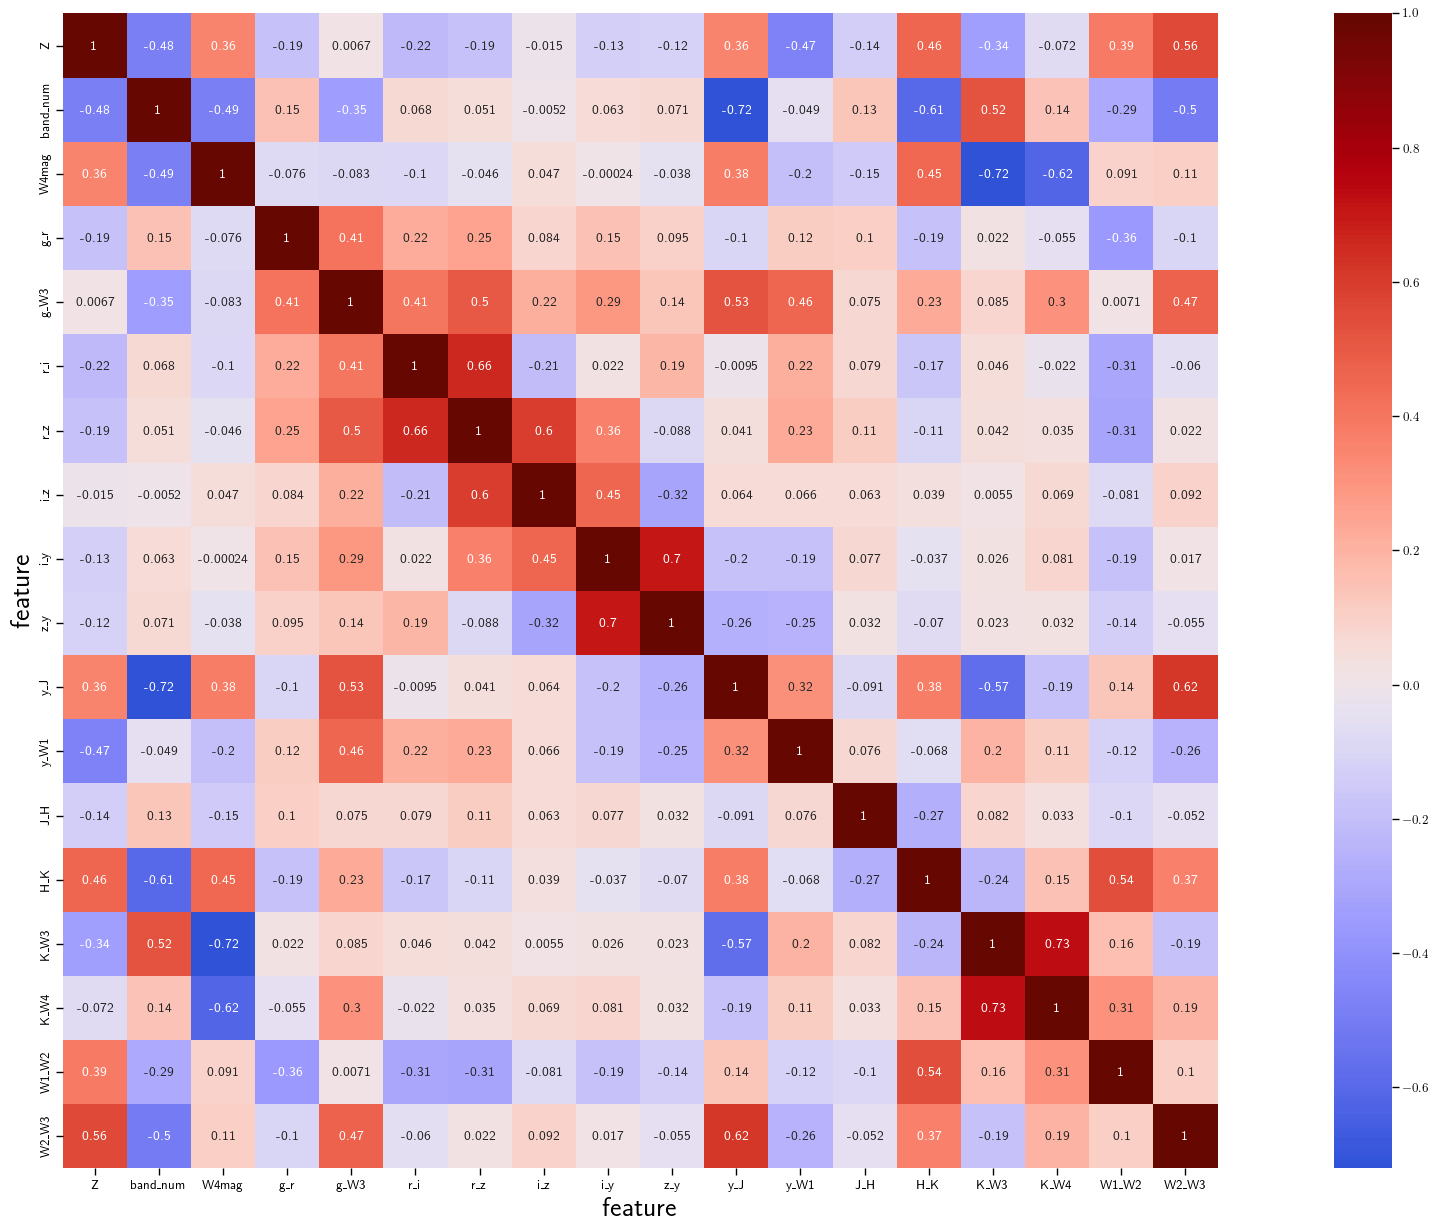

In [36]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [37]:
# norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [38]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [39]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
H_K       H_K         1.000000
K_W4      W4mag       0.479150
Z         H_K         0.456973
band_num  y_J         0.446378
K_W4      K_W3        0.405665
J_H       band_num    0.389886
K_W3      K_W4        0.386024
H_K       band_num    0.379027
J_H       H_K         0.369832
W4mag     K_W3        0.355117
band_num  H_K         0.238120
K_W3      W4mag       0.233152
y_J       band_num    0.210900
K_W3      y_J         0.210048
band_num  Z           0.187089
H_K       Z           0.184733
K_W4      y_J         0.176208
J_H       Z           0.175550
K_W4      band_num    0.172781
J_H       y_J         0.170078
dtype: float64

In [40]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [41]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [42]:
list_drop_pps = []

In [43]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [44]:
list_drop_pps

[]

In [45]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [46]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [47]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0.187089,regression,True,mean absolute error,0.146359,0.118977,DecisionTreeRegressor()
1,H_K,Z,0.184733,regression,True,mean absolute error,0.146359,0.119321,DecisionTreeRegressor()
2,J_H,Z,0.175550,regression,True,mean absolute error,0.146359,0.120665,DecisionTreeRegressor()
3,K_W4,Z,0.153360,regression,True,mean absolute error,0.146359,0.123913,DecisionTreeRegressor()
4,W4mag,Z,0.091175,regression,True,mean absolute error,0.146359,0.133014,DecisionTreeRegressor()
5,W1_W2,Z,0.054810,regression,True,mean absolute error,0.146359,0.138337,DecisionTreeRegressor()
6,K_W3,Z,0.026197,regression,True,mean absolute error,0.146359,0.142525,DecisionTreeRegressor()
7,W2_W3,Z,0.017026,regression,True,mean absolute error,0.146359,0.143867,DecisionTreeRegressor()
8,y_W1,Z,0.012106,regression,True,mean absolute error,0.146359,0.144587,DecisionTreeRegressor()
9,g_r,Z,0.000000,regression,True,mean absolute error,0.146359,0.173265,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [48]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
# final_feats.remove('J_H')       # After Boruta

In [49]:
feats_2_discard = list_drop_corr + list_drop_pps#  + ['J_H']

Boruta discards one feature.

In [50]:
exp_radio = pyr.setup(data                     = train_df,
                      test_data                = test_df,
                      target                   = target_feat,
                      session_id               = gv.seed,
                      silent                   = True,
                      feature_selection        = False,
                      feature_selection_method = 'boruta',
                      numeric_features         = final_feats,
                      ignore_features          = feats_2_discard,
                      transformation           = True,
                      transformation_method    = 'yeo-johnson',
                      n_jobs                   = 12,
                      normalize                = True,
                      normalize_method         = 'zscore',
                      use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(4091, 80)"
3,Missing Values,False
4,Numeric Features,17
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4091, 17)"


Add custom metrics

In [51]:
pyr.add_metric('s_mad',  'sigma_mad',    gf.sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   gf.sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      gf.sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', gf.sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   gf.outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7fc5a5dd29d0>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [52]:
pyr.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'g_W3', 'r_i', 'r_z', 'i_z', 'i_y', 'z_y',
       'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W2_W3'],
      dtype='object')

In [53]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [54]:
pyr.models(internal=True).loc['rf']['Tune Grid'].keys()

dict_keys(['n_estimators', 'max_depth', 'min_impurity_decrease', 'max_features', 'bootstrap', 'criterion', 'min_samples_split', 'min_samples_leaf'])

In [55]:
pyr.models(internal=True).loc['et']['Tune Grid'].keys()

dict_keys(['n_estimators', 'criterion', 'max_depth', 'min_impurity_decrease', 'max_features', 'bootstrap', 'min_samples_split', 'min_samples_leaf'])

In [56]:
pyr.models(internal=True).loc['catboost']['Tune Grid'].keys()

dict_keys(['eta', 'depth', 'n_estimators', 'random_strength', 'l2_leaf_reg'])

In [57]:
pyr.models(internal=True).loc['xgboost']['Tune Grid'].keys()

dict_keys(['learning_rate', 'n_estimators', 'subsample', 'max_depth', 'colsample_bytree', 'min_child_weight', 'reg_alpha', 'reg_lambda', 'scale_pos_weight'])

In [58]:
pyr.models(internal=True).loc['gbr']['Tune Grid'].keys()

dict_keys(['n_estimators', 'learning_rate', 'subsample', 'min_samples_split', 'min_samples_leaf', 'max_depth', 'min_impurity_decrease', 'max_features'])

In [59]:
dummy_median = DummyRegressor(strategy='median')

In [60]:
rf = pyr.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2024,0.1090,0.3301,0.8533,0.1383,0.4451,0.1727,0.0792,0.3301,0.1618,0.1537
1,0.2421,0.2005,0.4478,0.7424,0.1711,0.3470,0.1933,0.0839,0.4478,0.1749,0.1980
2,0.2516,0.2055,0.4534,0.7414,0.1795,0.3826,0.1569,0.0716,0.4534,0.2178,0.1932
3,0.2701,0.2164,0.4652,0.7339,0.1777,0.3669,0.2072,0.0894,0.4652,0.1821,0.2200
4,0.2547,0.1861,0.4314,0.7762,0.1664,0.3282,0.1802,0.0828,0.4314,0.1834,0.2152
5,0.2317,0.1547,0.3934,0.7935,0.1583,0.3385,0.1691,0.0739,0.3934,0.1792,0.1834
6,0.2814,0.2763,0.5256,0.6356,0.2027,0.3615,0.1854,0.0804,0.5256,0.2443,0.2225
7,0.2388,0.1563,0.3953,0.7919,0.1707,0.4456,0.1826,0.0801,0.3953,0.2180,0.1907
8,0.2195,0.1395,0.3735,0.8106,0.1579,0.3553,0.1788,0.0740,0.3735,0.2007,0.1785


In [61]:
et = pyr.create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2105,0.1266,0.3559,0.8295,0.1426,0.4227,0.1718,0.0806,0.3559,0.1618,0.1634
1,0.2387,0.1692,0.4113,0.7827,0.1601,0.3783,0.1875,0.0837,0.4113,0.1696,0.2005
2,0.2609,0.2218,0.4710,0.7209,0.1805,0.3825,0.1867,0.0861,0.4710,0.2122,0.1956
3,0.2570,0.1994,0.4465,0.7549,0.1673,0.4444,0.1967,0.0914,0.4465,0.1671,0.2078
4,0.2448,0.1736,0.4166,0.7913,0.1583,0.3282,0.1800,0.0777,0.4166,0.1765,0.1932
5,0.2322,0.1602,0.4002,0.7862,0.1604,0.3558,0.1768,0.0847,0.4002,0.1775,0.1834
6,0.2628,0.2324,0.4821,0.6935,0.1827,0.3326,0.1751,0.0814,0.4821,0.2236,0.2005
7,0.2315,0.1399,0.3740,0.8137,0.1658,0.4961,0.1785,0.0828,0.3740,0.2122,0.1883
8,0.2333,0.1544,0.3929,0.7903,0.1630,0.3763,0.1941,0.0817,0.3929,0.2041,0.1932


In [62]:
ctbst = pyr.create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2250,0.1270,0.3564,0.8290,0.1461,0.5793,0.2132,0.0933,0.3564,0.1689,0.1976
1,0.2635,0.1875,0.4330,0.7591,0.1752,0.4548,0.2175,0.1030,0.4330,0.1999,0.2298
2,0.2546,0.1854,0.4305,0.7668,0.1688,0.4230,0.1922,0.0946,0.4305,0.1977,0.2078
3,0.2648,0.1911,0.4371,0.7651,0.1650,0.5509,0.2478,0.1088,0.4371,0.1671,0.2200
4,0.2596,0.1689,0.4110,0.7969,0.1607,0.4010,0.2225,0.0992,0.4110,0.1817,0.2543
5,0.2386,0.1419,0.3767,0.8106,0.1534,0.3649,0.2180,0.1041,0.3767,0.1721,0.2029
6,0.2628,0.1937,0.4401,0.7445,0.1724,0.5117,0.2022,0.0969,0.4401,0.2034,0.2225
7,0.2460,0.1354,0.3679,0.8197,0.1615,0.5891,0.2161,0.1015,0.3679,0.1955,0.2103
8,0.2456,0.1666,0.4081,0.7738,0.1671,0.4126,0.2159,0.0999,0.4081,0.1954,0.2298


In [63]:
xgbst = pyr.create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2399,0.1349,0.3673,0.8183,0.1513,0.5493,0.2432,0.1127,0.3673,0.1692,0.2220
1,0.2683,0.2013,0.4487,0.7414,0.1788,0.4854,0.2380,0.1104,0.4487,0.1964,0.2543
2,0.2884,0.2377,0.4876,0.7009,0.1916,0.4696,0.2261,0.1005,0.4876,0.2250,0.2249
3,0.2953,0.2282,0.4777,0.7194,0.1828,0.5373,0.2351,0.1243,0.4777,0.1851,0.2836
4,0.2665,0.1789,0.4230,0.7849,0.1679,0.5760,0.2131,0.0968,0.4230,0.1820,0.2518
5,0.2596,0.1746,0.4178,0.7670,0.1703,0.3791,0.2311,0.1127,0.4178,0.1842,0.2274
6,0.2771,0.2321,0.4818,0.6938,0.1876,0.4551,0.2070,0.0989,0.4818,0.2267,0.2494
7,0.2520,0.1426,0.3776,0.8100,0.1613,0.6086,0.2286,0.1090,0.3776,0.1869,0.2347
8,0.2584,0.1791,0.4232,0.7568,0.1763,0.5575,0.2327,0.1062,0.4232,0.2074,0.2225


In [64]:
gbr = pyr.create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2557,0.1447,0.3804,0.8051,0.1581,0.7518,0.2597,0.1171,0.3804,0.1834,0.2341
1,0.3061,0.2331,0.4828,0.7005,0.1932,0.4908,0.2931,0.1357,0.4828,0.2147,0.2934
2,0.3008,0.2439,0.4939,0.6931,0.1910,0.4694,0.2510,0.1148,0.4939,0.2232,0.2641
3,0.3144,0.2408,0.4907,0.7040,0.1897,0.5521,0.3056,0.1384,0.4907,0.1896,0.3227
4,0.3045,0.2152,0.4639,0.7412,0.1803,0.5390,0.2751,0.1317,0.4639,0.1991,0.2934
5,0.2714,0.1707,0.4132,0.7721,0.1694,0.4255,0.2710,0.1238,0.4132,0.1806,0.2910
6,0.3032,0.2367,0.4865,0.6878,0.1887,0.4897,0.2740,0.1249,0.4865,0.2146,0.3032
7,0.2890,0.1789,0.4229,0.7617,0.1823,0.5973,0.2707,0.1239,0.4229,0.2245,0.2934
8,0.2833,0.1811,0.4255,0.7540,0.1806,0.6049,0.2782,0.1272,0.4255,0.2224,0.2812


In [65]:
dummy_mn = pyr.create_model(dummy_median)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.7187,0.7435,0.8623,-0.0010,0.3969,3.2797,1.0249,0.4216,0.8623,0.4893,0.7293
1,0.7278,0.7816,0.8841,-0.0042,0.3965,2.2443,0.9716,0.4106,0.8841,0.4796,0.7555
2,0.7222,0.7986,0.8937,-0.0049,0.3963,2.6022,0.9753,0.3893,0.8937,0.4801,0.7286
3,0.7634,0.8268,0.9093,-0.0165,0.3995,3.4682,1.0649,0.4420,0.9093,0.4729,0.8044
4,0.7478,0.8450,0.9192,-0.0159,0.4029,4.1085,1.0079,0.4310,0.9192,0.4796,0.7188
5,0.7096,0.7518,0.8670,-0.0034,0.3935,2.1746,1.0116,0.3962,0.8670,0.4800,0.7164
6,0.7078,0.7594,0.8715,-0.0018,0.3902,2.5860,0.9309,0.3927,0.8715,0.4742,0.7384
7,0.7211,0.7568,0.8700,-0.0081,0.3959,3.4919,0.9857,0.4128,0.8700,0.4829,0.7164
8,0.7129,0.7488,0.8653,-0.0170,0.3863,2.7308,0.9583,0.3915,0.8653,0.4631,0.7531


In [66]:
metric_2_opt          = 's_mad'

In [67]:
# final_selection_reg   = ['rf', 'et', 'catboost', 'xgboost', 'gbr', 'dummy']  # knn discarded: no feature importances
final_selection_reg   = [rf, et, ctbst, xgbst, gbr, dummy_mn]
initial_selection_reg = ['rf', 'et', 'gbr', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, dt)
n_models              = 5
top_model_z           = pyr.compare_models(n_select = n_models,
                                           include  = final_selection_reg,
                                           sort     = metric_2_opt)  # 1:15 hour for used_models_clf
# top_model_z           = pyr.compare_models(n_select=n_models, include=initial_selection_reg, sort=metric_2_opt)  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
0,Random Forest Regressor,0.2419,0.1794,0.4202,0.7681,0.1681,0.3660,0.1788,0.0795,0.4202,0.1938,0.1951,0.2150
1,Extra Trees Regressor,0.2399,0.1708,0.4112,0.7791,0.1630,0.3812,0.1853,0.0842,0.4112,0.1865,0.1924,0.0970
2,CatBoost Regressor,0.2503,0.1637,0.4035,0.7880,0.1624,0.4711,0.2171,0.1008,0.4035,0.1852,0.2193,0.5600
3,Extreme Gradient Boosting,0.2669,0.1877,0.4314,0.7571,0.1738,0.5041,0.2289,0.1084,0.4314,0.1962,0.2415,9.1020
4,Gradient Boosting Regressor,0.2914,0.2023,0.4482,0.7384,0.1806,0.5376,0.2773,0.1272,0.4482,0.2041,0.2867,0.1590
5,Dummy Regressor,0.7239,0.7769,0.8812,-0.0073,0.3957,2.9408,0.9913,0.4068,0.8812,0.4797,0.7380,0.0080


Thus, we select `et` as meta learner. It has the best mean rank.

Thus, we stack the models.

In [59]:
# base_models = top_model_z[1:]
# meta_model  = top_model_z[0]
base_models = top_model_z[0:1] + top_model_z[2:]
meta_model  = top_model_z[1]

In [60]:
stacked_model_z = pyr.stack_models(estimator_list = base_models,
                                   meta_model     = meta_model,
                                   optimize       = metric_2_opt, 
                                   restack        = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.1900,0.1016,0.3188,0.8632,0.1278,0.3803,0.1470,0.0700,0.3188,0.1441,0.1488
1,0.2352,0.1889,0.4347,0.7573,0.1744,0.3881,0.1628,0.0769,0.4347,0.2148,0.1907
2,0.2329,0.1786,0.4226,0.7753,0.1661,0.3361,0.1491,0.0720,0.4226,0.2026,0.1687
3,0.2371,0.1813,0.4258,0.7771,0.1563,0.3189,0.1781,0.0771,0.4258,0.1619,0.1907
4,0.2255,0.1553,0.3940,0.8133,0.1519,0.2912,0.1641,0.0696,0.3940,0.1731,0.1614
5,0.2111,0.1323,0.3638,0.8234,0.1482,0.2918,0.1743,0.0786,0.3638,0.1707,0.1589
6,0.2461,0.2085,0.4567,0.7249,0.1765,0.3242,0.1468,0.0754,0.4567,0.2212,0.1663
7,0.2128,0.1190,0.3449,0.8415,0.1495,0.3546,0.1552,0.0705,0.3449,0.1822,0.1785
8,0.2142,0.1445,0.3801,0.8038,0.1531,0.3111,0.1637,0.0700,0.3801,0.1865,0.1809


In [55]:
# rf_tune_grid                 = pyr.models(internal=True).loc['rf']['Tune Grid']
# rf_tune_grid['max_depth']    = [3, 4, 5, 6, 7, 8, 9, 10, 11]  # old = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# rf_tune_grid['max_features'] = [0.25, 0.33, 0.66]  # old = [1.0, 'sqrt', 'log2']

In [61]:
# tuned_z_reg = pyr.tune_model(estimator        = stacked_model_z,
#                              early_stopping   = True,
#                              optimize         = metric_2_opt,
#                              search_library   = 'tune-sklearn',
#                              search_algorithm = 'bayesian',
#                              choose_better    = True,
#                              custom_grid      = rf_tune_grid)  # 1h30
tuned_z_reg = pyr.tune_model(estimator        = stacked_model_z,
                             early_stopping   = True,
                             optimize         = metric_2_opt,
                             search_library   = 'tune-sklearn',
                             search_algorithm = 'bayesian',
                             choose_better    = True)  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.1999,0.1065,0.3264,0.8566,0.1281,0.3824,0.1709,0.0842,0.3264,0.1444,0.1390
1,0.2397,0.1754,0.4188,0.7746,0.1635,0.3761,0.1919,0.0865,0.4188,0.1704,0.1956
2,0.2385,0.1824,0.4270,0.7705,0.1646,0.3166,0.1451,0.0728,0.4270,0.1875,0.1638
3,0.2496,0.1969,0.4437,0.7579,0.1626,0.3372,0.1983,0.0908,0.4437,0.1577,0.1956
4,0.2411,0.1568,0.3960,0.8114,0.1521,0.3133,0.1806,0.0802,0.3960,0.1602,0.2054
5,0.2184,0.1390,0.3728,0.8145,0.1471,0.2824,0.1752,0.0761,0.3728,0.1574,0.1614
6,0.2584,0.2209,0.4700,0.7086,0.1783,0.3263,0.1670,0.0805,0.4700,0.2143,0.2005
7,0.2204,0.1244,0.3527,0.8343,0.1483,0.3796,0.1695,0.0797,0.3527,0.1779,0.1711
8,0.2165,0.1528,0.3909,0.7925,0.1570,0.3148,0.1516,0.0667,0.3909,0.1863,0.1565


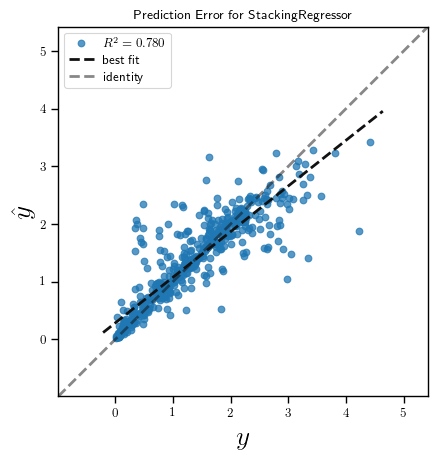

In [62]:
pyr.plot_model(tuned_z_reg, plot='error')

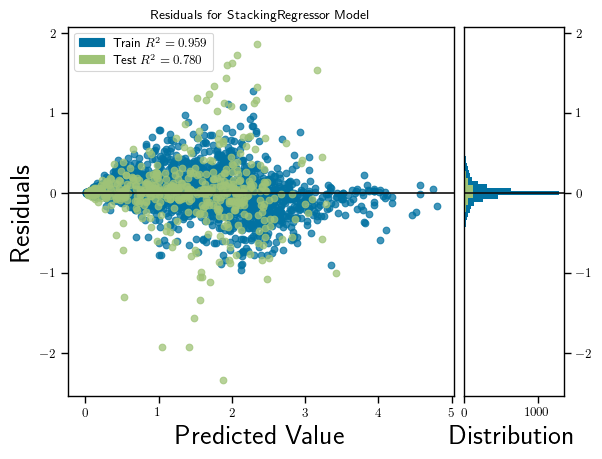

In [63]:
pyr.plot_model(tuned_z_reg, plot='residuals')

In [77]:
# pyr.plot_model(tuned_z_reg.final_estimator_, plot='feature_all')

In [64]:
pyr.plot_model(tuned_z_reg.final_estimator_, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,mse
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None
min_samples_leaf,1


In [65]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,mse
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None
min_samples_leaf,1


In [66]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [67]:
pyr.predict_model(tuned_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2361,0.1734,0.4164,0.7797,0.1657,0.3193,0.1467,0.0666,0.4164,0.1976,0.1823


,Z,Label
count,521.000000,521.000000
mean,1.277073,1.295552
std,0.888170,0.795853
min,0.007000,0.016080
25%,0.501000,0.587780
50%,1.185000,1.321590
75%,1.915000,1.934910
max,4.417000,3.420450


In [68]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2361,0.1734,0.4164,0.7797,0.1657,0.3193,0.1467,0.0666,0.4164,0.1976,0.1823


In [69]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [70]:
pyr.predict_model(final_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2361,0.1734,0.4164,0.7797,0.1657,0.3193,0.1467,0.0666,0.4164,0.1976,0.1823


,Z,Label
count,521.000000,521.000000
mean,1.277073,1.295552
std,0.888170,0.795853
min,0.007000,0.016080
25%,0.501000,0.587780
50%,1.185000,1.321590
75%,1.915000,1.934910
max,4.417000,3.420450


In [71]:
if save_model_flag:
    pyr.save_model(final_z_reg, gv.models_path + gv.full_z_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [67]:
if load_model_flag:
    final_z_reg = pyr.load_model(gv.models_path + gv.full_z_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [68]:
base_models_names = gf.get_base_estimators_names(final_z_reg)
base_models       = gf.get_base_estimators_models(final_z_reg)

In [69]:
print('Running data pre-processing:\n')
extended_data_z_df = gf.preprocess_data(final_z_reg, validation_df, base_models_names)

Running data pre-processing:



In [70]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_z_reg, extended_data_z_df)

In [71]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_z_df)

In [72]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [73]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for rf...
Calculating for catboost...
Calculating for xgboost...
Calculating for gbr...


rf             catboost              xgboost                  gbr  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0       y_W1  34.320379      y_W1  27.918493       H_K  24.002115      y_W1   
1   band_num  13.585272     W1_W2  13.729357      y_W1  20.434988     W2_W3   
2      W2_W3  10.934175     W2_W3  12.509537  band_num  14.431336       y_J   
3      W1_W2  10.761363       g_r   7.537733     W2_W3   8.262634     W1_W2   
4        g_r   7.079831       H_K   5.024253       y_J   5.945001  band_num   
5        y_J   4.810083       r_z   4.719836     W1_W2   5.369307       H_K   
6        r_i   3.287263  band_num   4.553584       J_H   5.309918       g_r   
7        H_K   3.140511       z_y   4.407290       g_r   2.344918     W4mag   
8        r_z   2.685249       y_J   4.382174     W4mag   2.263957       z_y   
9        z_y   2.110796       i_y   3.627915       z_y   2.185305       r_z   
10       i_z   1.983903       r_i   3.462596       r_z   1.808916       r_i   
11       i_y   1.965450       i_z   2.361771       r_i   1.620850       i_z   
12      g_W3   1.269744      g_W3   1.877378      K_W3   1.547184       i_y   
13      K_W3   0.757839      K_W3   1.857214       i_y   1.308786      g_W3   
14      K_W4   0.485609     W4mag   1.131166       i_z   1.228961      K_W4   
15     W4mag   0.430545      K_W4   0.688295      K_W4   1.095093       J_H   
16       J_H   0.391989       J_H   0.211408      g_W3   0.840728      K_W3   

               
   Importance  
0   38.529274  
1   12.213496  
2   10.775259  
3   10.573466  
4    9.525563  
5    5.619498  
6    4.902401  
7    2.651444  
8    1.648445  
9    1.084754  
10   1.036519  
11   0.464317  
12   0.369994  
13   0.233661  
14   0.166390  
15   0.119581  
16   0.085937

In [74]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
coef_sorted_meta_df_copy_sum['Cumulative_sum'] = coef_sorted_meta_df_copy_sum.loc[:, 'Importance'].cumsum()
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance,Cumulative_sum
0,xgboost,25.138380,25.138380
1,gbr,21.863688,47.002068
2,catboost,21.071922,68.073990
3,rf,13.708734,81.782723
4,W1_W2,2.113325,83.896049
5,g_r,1.999680,85.895728
6,y_W1,1.754283,87.650012
7,r_i,1.434877,89.084888
8,r_z,1.229623,90.314511
9,i_z,1.152596,91.467107


In [75]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
    coef_sorted_comb_sum = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False)#.drop(index=base_models_names)
    coef_sorted_comb_sum['Cumulative_sum'] = coef_sorted_comb_sum.loc[:, 'Importance'].cumsum()
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Cumulative_sum,Importance
Feature,,
y_W1,25.9031,25.9031
W1_W2,36.0462,10.1431
W2_W3,46.0779,10.0317
band_num,55.7400,9.6621
H_K,65.0823,9.3423
g_r,71.3022,6.2199
y_J,77.4527,6.1505
r_z,80.7369,3.2842
r_i,83.9862,3.2492


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
y_W1	25.903
W1_W2	10.143
W2_W3	10.032
band_num	9.662
H_K	9.342
g_r	6.220
y_J	6.151
r_z	3.284
r_i	3.249
z_y	3.048
W4mag	2.572
i_y	2.421
i_z	2.333
J_H	1.742
g_W3	1.694
K_W3	1.406
K_W4	0.798


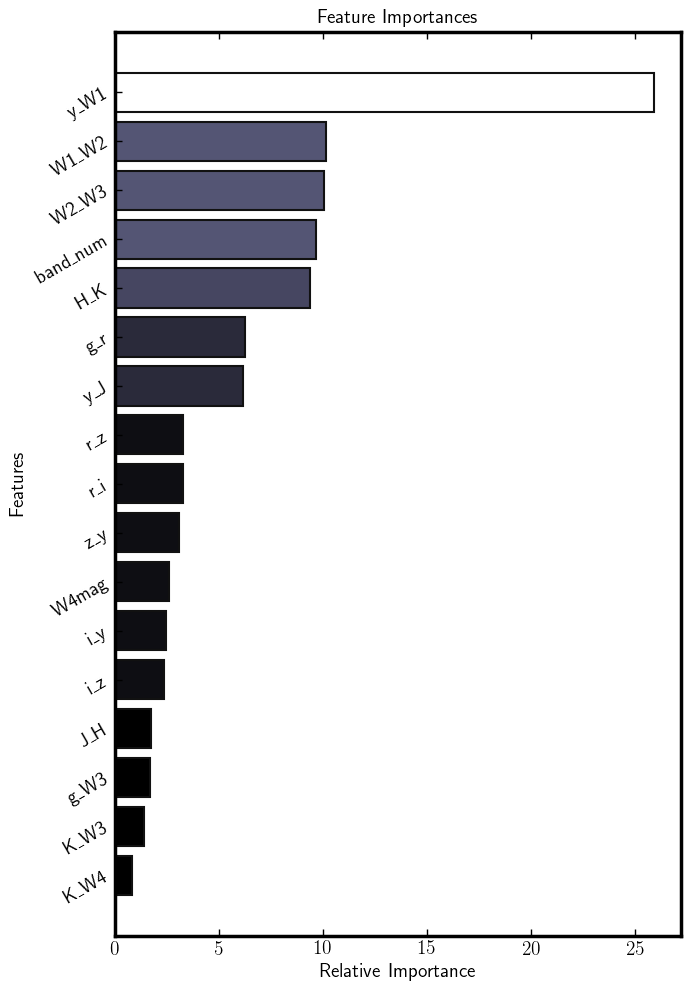

In [76]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_regression_z_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [77]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_z_reg, 'rf', 'regression')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,rf,rf,catboost,xgboost,gbr
n_estimators,100,100.0000,NaN,100.0000,100.0000
max_depth,None,NaN,NaN,6.0000,3.0000
min_impurity_decrease,0.0000,0.0000,NaN,NaN,0.0000
max_features,auto,auto,NaN,NaN,None
bootstrap,False,True,NaN,NaN,NaN
criterion,mse,mse,NaN,NaN,NaN
min_samples_split,2,2.0000,NaN,NaN,2.0000
min_samples_leaf,1,1.0000,NaN,NaN,1.0000
learning_rate,NaN,NaN,0.0512,0.3000,0.1000
depth,NaN,NaN,6.0000,NaN,NaN


---

In [78]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 4,091
Size of test set is  521


In [79]:
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)
calib_prediction_reg      = pyr.predict_model(final_z_reg, data=calibration_df)
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1042,0.0318,0.1783,0.9588,0.0729,0.1239,0.0731,0.0324,0.1783,0.0788,0.0599


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2361,0.1734,0.4164,0.7797,0.1657,0.3193,0.1467,0.0666,0.4164,0.1976,0.1823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1315,0.0631,0.2511,0.9184,0.1017,0.1656,0.0840,0.0380,0.2511,0.1189,0.0861


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2436,0.2014,0.4488,0.7353,0.1825,0.3438,0.1748,0.0746,0.4488,0.2288,0.1984


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2295,0.1693,0.4114,0.7663,0.1649,0.3201,0.1653,0.0727,0.4114,0.2056,0.1903


In [80]:
validation_prediction_reg.loc[:, [target_feat, 'Label']].describe()

,Z,Label
count,1298.000000,1298.000000
mean,1.289703,1.332130
std,0.851377,0.781656
min,0.015000,0.031530
25%,0.565250,0.704805
50%,1.244500,1.312960
75%,1.866500,1.918302
max,4.680000,4.196830


In [81]:
sigma_mad_train         = gf.sigma_mad(train_prediction_reg.loc[:, target_feat],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test          = gf.sigma_mad(test_prediction_reg.loc[:, target_feat],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_train_test    = gf.sigma_mad(train_test_prediction_reg.loc[:, target_feat],    train_test_prediction_reg.loc[:, 'Label'])
sigma_mad_calib         = gf.sigma_mad(calib_prediction_reg.loc[:, target_feat],         calib_prediction_reg.loc[:, 'Label'])
sigma_mad_valid         = gf.sigma_mad(validation_prediction_reg.loc[:, target_feat],    validation_prediction_reg.loc[:, 'Label'])

In [82]:
sigma_nmad_train        = gf.sigma_nmad(train_prediction_reg.loc[:, target_feat],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test         = gf.sigma_nmad(test_prediction_reg.loc[:, target_feat],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_train_test   = gf.sigma_nmad(train_test_prediction_reg.loc[:, target_feat],   train_test_prediction_reg.loc[:, 'Label'])
sigma_nmad_calib        = gf.sigma_nmad(calib_prediction_reg.loc[:, target_feat],        calib_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid        = gf.sigma_nmad(validation_prediction_reg.loc[:, target_feat],   validation_prediction_reg.loc[:, 'Label'])

In [83]:
sigma_z_train           = gf.sigma_z(train_prediction_reg.loc[:, target_feat],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test            = gf.sigma_z(test_prediction_reg.loc[:, target_feat],            test_prediction_reg.loc[:, 'Label'])
sigma_z_train_test      = gf.sigma_z(train_test_prediction_reg.loc[:, target_feat],      train_test_prediction_reg.loc[:, 'Label'])
sigma_z_calib           = gf.sigma_z(calib_prediction_reg.loc[:, target_feat],           calib_prediction_reg.loc[:, 'Label'])
sigma_z_valid           = gf.sigma_z(validation_prediction_reg.loc[:, target_feat],      validation_prediction_reg.loc[:, 'Label'])

In [84]:
sigma_z_norm_train      = gf.sigma_z_norm(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test       = gf.sigma_z_norm(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_train_test = gf.sigma_z_norm(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_calib      = gf.sigma_z_norm(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid      = gf.sigma_z_norm(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

In [85]:
out_frac_train          = gf.outlier_frac(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
out_frac_test           = gf.outlier_frac(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
out_frac_train_test     = gf.outlier_frac(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
out_frac_calib          = gf.outlier_frac(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
out_frac_valid          = gf.outlier_frac(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

Display metrics as DataFrame

In [86]:
metrics_z = np.array([[len(train_prediction_reg),      sigma_mad_train,      sigma_nmad_train,\
                       sigma_z_train,      sigma_z_norm_train,      out_frac_train],\
                      [len(test_prediction_reg),       sigma_mad_test,       sigma_nmad_test,\
                       sigma_z_test,       sigma_z_norm_test,       out_frac_test],\
                      [len(train_test_prediction_reg), sigma_mad_train_test, sigma_nmad_train_test,\
                       sigma_z_train_test, sigma_z_norm_train_test, out_frac_train_test],\
                      [len(calib_prediction_reg),      sigma_mad_calib,      sigma_nmad_calib,\
                       sigma_z_calib,      sigma_z_norm_calib,      out_frac_calib],\
                      [len(validation_prediction_reg), sigma_mad_valid,      sigma_nmad_valid,\
                       sigma_z_valid,      sigma_z_norm_valid,      out_frac_valid]])

In [87]:
metrics_z_df = pd.DataFrame(data=metrics_z, index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])

In [88]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
    display(metrics_z_df)

,Sample,σ MAD,σ NMAD,σ z,σ z N,η
Train,4091,0.0731,0.0324,0.1783,0.0788,0.0599
Test,521,0.1467,0.0666,0.4164,0.1976,0.1823
Train+Test,5121,0.0840,0.0380,0.2511,0.1189,0.0861
Calibration,509,0.1748,0.0746,0.4488,0.2288,0.1984
Validation,1298,0.1653,0.0727,0.4114,0.2056,0.1903


Mean biases per sub-set.

In [89]:
res_z_train      = (train_prediction_reg.loc[:, 'Label']      -
                    train_prediction_reg.loc[:, target_feat])      / (1 + train_prediction_reg.loc[:, target_feat])
res_z_test       = (test_prediction_reg.loc[:, 'Label']       -
                    test_prediction_reg.loc[:, target_feat])       / (1 + test_prediction_reg.loc[:, target_feat])
res_z_train_test = (train_test_prediction_reg.loc[:, 'Label'] -
                    train_test_prediction_reg.loc[:, target_feat]) / (1 + train_test_prediction_reg.loc[:, target_feat])
res_z_calib      = (calib_prediction_reg.loc[:, 'Label']      -
                    calib_prediction_reg.loc[:, target_feat])      / (1 + calib_prediction_reg.loc[:, target_feat])
res_z_validation = (validation_prediction_reg.loc[:, 'Label'] -
                    validation_prediction_reg.loc[:, target_feat]) / (1 + validation_prediction_reg.loc[:, target_feat])

In [90]:
stats_res_z  = np.array([[len(train_prediction_reg),      np.nanmean(res_z_train),      np.nanstd(res_z_train)],
                         [len(test_prediction_reg),       np.nanmean(res_z_test),       np.nanstd(res_z_test)], 
                         [len(train_test_prediction_reg), np.nanmean(res_z_train_test), np.nanstd(res_z_train_test)],
                         [len(calib_prediction_reg),      np.nanmean(res_z_calib),      np.nanstd(res_z_calib)],
                         [len(validation_prediction_reg), np.nanmean(res_z_validation), np.nanstd(res_z_validation)]])

In [91]:
stats_res_z_df = pd.DataFrame(data=stats_res_z, index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                            columns=['Sample', 'Mean \u0394 z / (1 + z)', 'Std. dev. \u0394 z / (1 + z)'])

In [92]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    stats_res_z_df.loc[:, 'Sample'] = stats_res_z_df.loc[:, 'Sample'].astype(int)
    display(stats_res_z_df)

,Sample,Mean Δ z / (1 + z),Std. dev. Δ z / (1 + z)
Train,4091,0.0118,0.0779
Test,521,0.0355,0.1944
Train+Test,5121,0.0170,0.1177
Calibration,509,0.0391,0.2254
Validation,1298,0.0442,0.2007


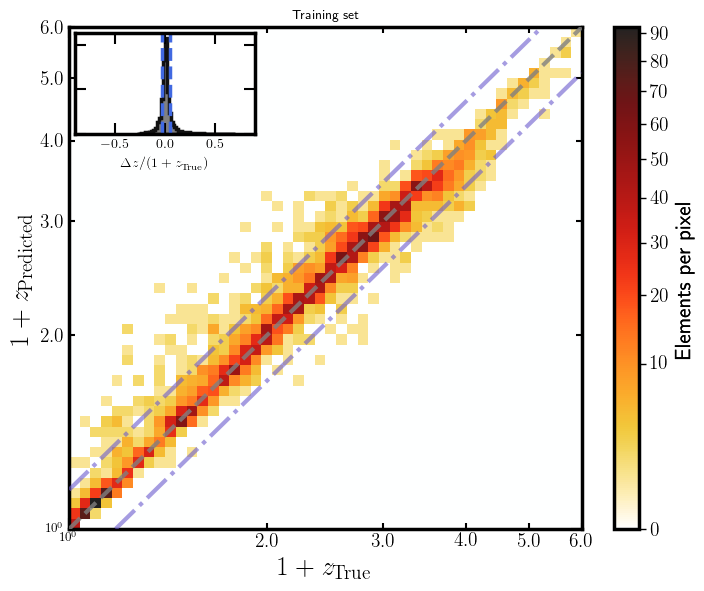

In [93]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(train_prediction_reg.loc[:, target_feat], train_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Training set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_train_redshift_04.pdf', bbox_inches='tight')
plt.show()

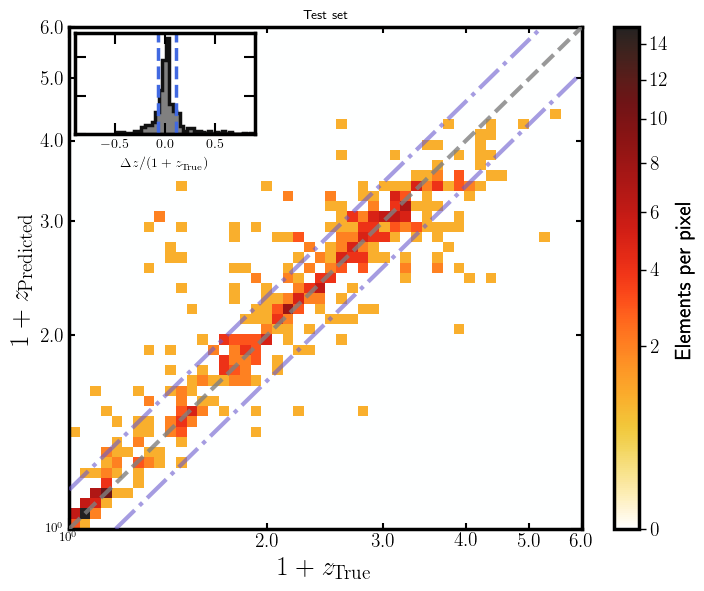

In [94]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(test_prediction_reg.loc[:, target_feat], test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_test_redshift_04.pdf', bbox_inches='tight')
plt.show()

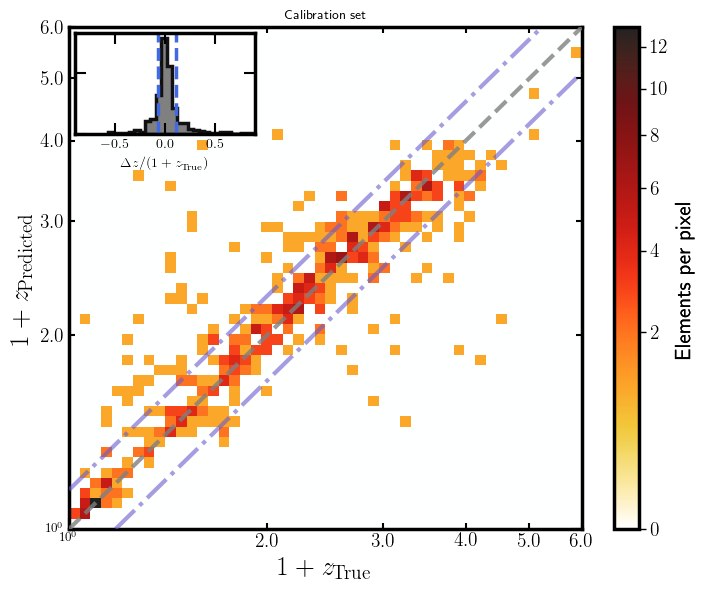

In [95]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(calib_prediction_reg.loc[:, target_feat], calib_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Calibration set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_calibration_redshift_04.pdf', bbox_inches='tight')
plt.show()

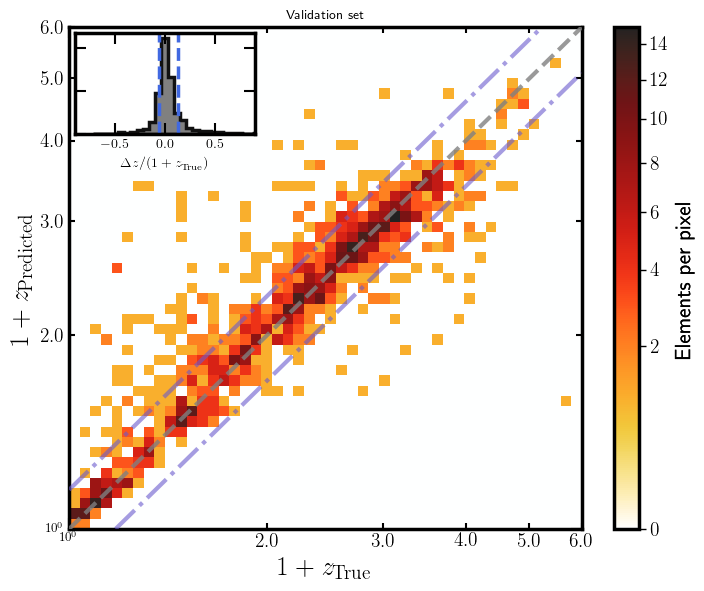

In [96]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Validation set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_validation_redshift_04.pdf', bbox_inches='tight')
plt.show()

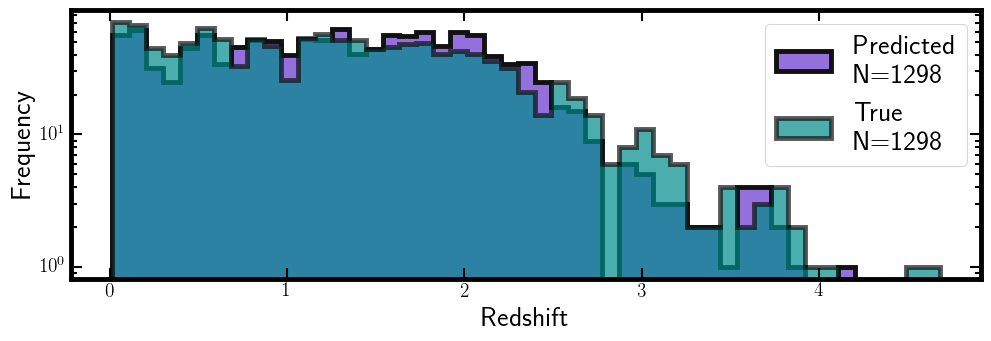

In [97]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, target_feat], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_true_predicted_z_04.pdf')
plt.show()

#### Obtain uncertainty values from model

In [102]:
subsets_arr = [train_prediction_reg, test_prediction_reg, 
               train_test_prediction_reg, calib_prediction_reg, 
               validation_prediction_reg]

In [103]:
subset_names = ['train', 'test', 'train + test', 'calibration', 'validation']

In [98]:
CV_object = KFold(n_splits=10, random_state=gv.seed, shuffle=True)

In [99]:
cv_scores = {}

In [105]:
for count, (subset, subset_name) in enumerate(zip(subsets_arr, subset_names)):
    tmp_s_mads  = []
    tmp_s_nmads = []
    tmp_s_zs    = []
    tmp_s_z_ns  = []
    tmp_out_fs  = []
    for _, fold_index in iter(CV_object.split(subset.loc[:, 'Label'], subset.loc[:, target_feat])):
        tmp_s_mad  = pyr.get_metrics().loc['s_mad', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                       subset.iloc[fold_index].loc[:, 'Label'])
        tmp_s_nmad = pyr.get_metrics().loc['s_nmad', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                    subset.iloc[fold_index].loc[:, 'Label'])
        tmp_s_z    = pyr.get_metrics().loc['s_z', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                          subset.iloc[fold_index].loc[:, 'Label'])
        tmp_s_z_n  = pyr.get_metrics().loc['s_z_n', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                       subset.iloc[fold_index].loc[:, 'Label'])
        tmp_out_f  = pyr.get_metrics().loc['out_f', 'Score Function'](subset.iloc[fold_index].loc[:, target_feat], 
                                                                       subset.iloc[fold_index].loc[:, 'Label'])
        tmp_s_mads.append(tmp_s_mad)
        tmp_s_nmads.append(tmp_s_nmad)
        tmp_s_zs.append(tmp_s_z)
        tmp_s_z_ns.append(tmp_s_z_n)
        tmp_out_fs.append(tmp_out_f)
    cv_scores[subset_name] = {'sigma_mad': tmp_s_mads, 'sigma_nmad': tmp_s_nmads, 
                              'sigma_z': tmp_s_zs, 'sigma_z_norm': tmp_s_z_ns, 
                              'outlier_fr':tmp_out_fs}

In [106]:
cv_scores_mean = {}
cv_scores_std  = {}

In [107]:
for sub_set in cv_scores:
    cv_scores_mean[sub_set] = {}
    cv_scores_std[sub_set] = {}
    for score in cv_scores[sub_set]:
        cv_scores_mean[sub_set][score] = np.nanmean(cv_scores[sub_set][score])
        cv_scores_std[sub_set][score]  = np.nanstd(cv_scores[sub_set][score])

In [108]:
for sub_set in cv_scores:
    print('-' * 20 + sub_set + '-' * 20)
    print(f'Sigma MAD score for {sub_set} set:          {cv_scores_mean[sub_set]["sigma_mad"]:.4f} ± {cv_scores_std[sub_set]["sigma_mad"]:.4f}')
    print(f'Sigma NMAD for {sub_set} set:               {cv_scores_mean[sub_set]["sigma_nmad"]:.4f} ± {cv_scores_std[sub_set]["sigma_nmad"]:.4f}')
    print(f'Sigma z for {sub_set} set:                  {cv_scores_mean[sub_set]["sigma_z"]:.4f} ± {cv_scores_std[sub_set]["sigma_z"]:.4f}')
    print(f'Normalized Sigma z score for {sub_set} set: {cv_scores_mean[sub_set]["sigma_z_norm"]:.4f} ± {cv_scores_std[sub_set]["sigma_z_norm"]:.4f}')
    print(f'Outlier fraction for {sub_set} set:         {cv_scores_mean[sub_set]["outlier_fr"]:.4f} ± {cv_scores_std[sub_set]["outlier_fr"]:.4f}')
    print('-' * 55)

--------------------train--------------------
Sigma MAD score for train set:          0.0725 ± 0.0086
Sigma NMAD for train set:               0.0327 ± 0.0039
Sigma z for train set:                  0.1777 ± 0.0151
Normalized Sigma z score for train set: 0.0785 ± 0.0068
Outlier fraction for train set:         0.0599 ± 0.0146
-------------------------------------------------------
--------------------test--------------------
Sigma MAD score for test set:          0.1495 ± 0.0458
Sigma NMAD for test set:               0.0677 ± 0.0185
Sigma z for test set:                  0.4110 ± 0.0687
Normalized Sigma z score for test set: 0.1929 ± 0.0434
Outlier fraction for test set:         0.1825 ± 0.0528
-------------------------------------------------------
--------------------train + test--------------------
Sigma MAD score for train + test set:          0.0843 ± 0.0052
Sigma NMAD for train + test set:               0.0380 ± 0.0020
Sigma z for train + test set:                  0.2506 ± 0.0155


---

#### Redshift threshold

In order to understand where (in redshift) the predictions are far off from real values, we can use the evolution of the outlier fraction to obtain the point where that happens.

In [109]:
n_elems        = 50
z_range_lin    = np.linspace(0, np.nanmax(train_test_prediction_reg.loc[:, target_feat]), n_elems)
z_range_log    = np.logspace(np.log10(np.abs(np.nanmin(train_test_prediction_reg.loc[:, target_feat]))),\
                          np.log10(np.abs(np.nanmax(train_test_prediction_reg.loc[:, target_feat]))), n_elems)
z_range_lg_inv = np.abs(np.abs(np.nanmax(train_test_prediction_reg.loc[:, target_feat]))) - z_range_log

In [110]:
train_test_prediction_reg = train_test_prediction_reg.rename(columns={'Label': 'pred_Z'})

In [111]:
s_MAD_z_z_lin          = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_lin        = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_lin      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.outlier_frac,   target_feat,            'pred_Z')

In [112]:
s_MAD_z_z_log          = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_log        = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_log      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.outlier_frac,   target_feat,            'pred_Z')

In [113]:
s_MAD_z_z_log_inv      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_log_inv    = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_log_inv  = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.outlier_frac,   target_feat,            'pred_Z')

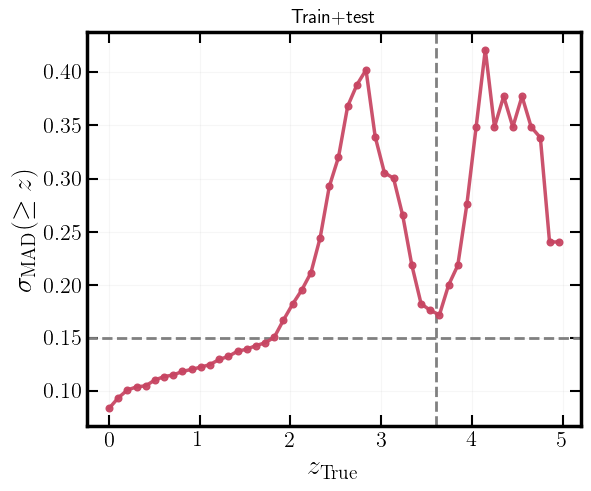

In [114]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_MAD_z_z_lin, '\sigma_{MAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'sigma_mad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

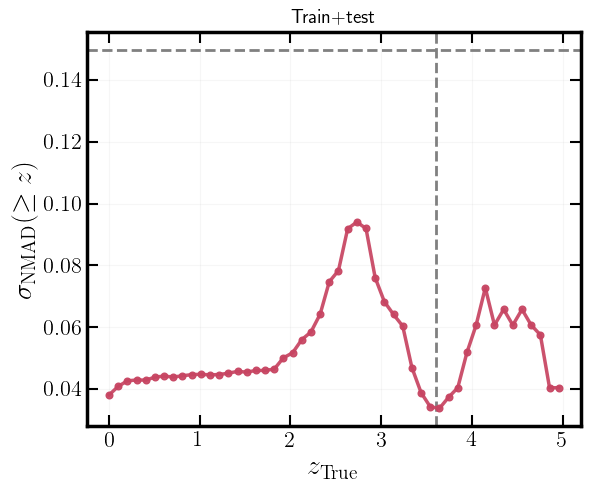

In [115]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_NMAD_z_z_lin, '\sigma_{NMAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'sigma_nmad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

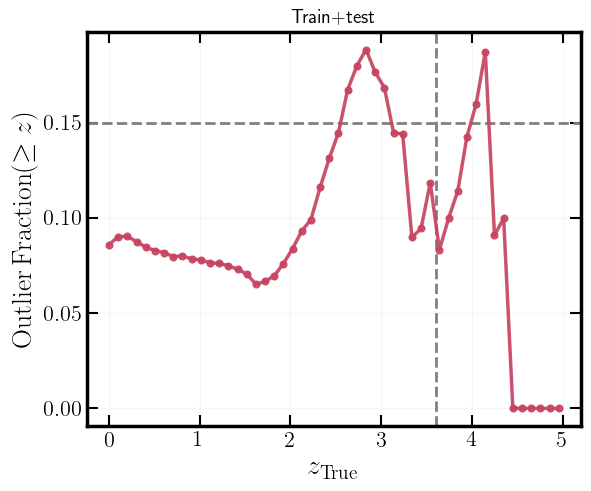

In [116]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, out_fr_z_z_lin, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

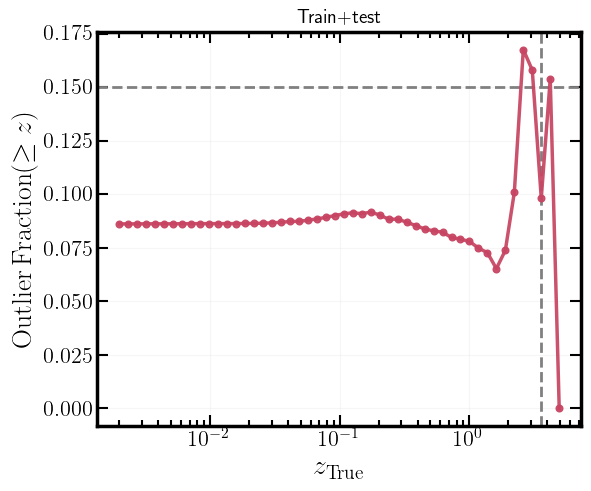

In [117]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='log', yscale='linear')
plot_metric_over_z(z_range_log, out_fr_z_z_log, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

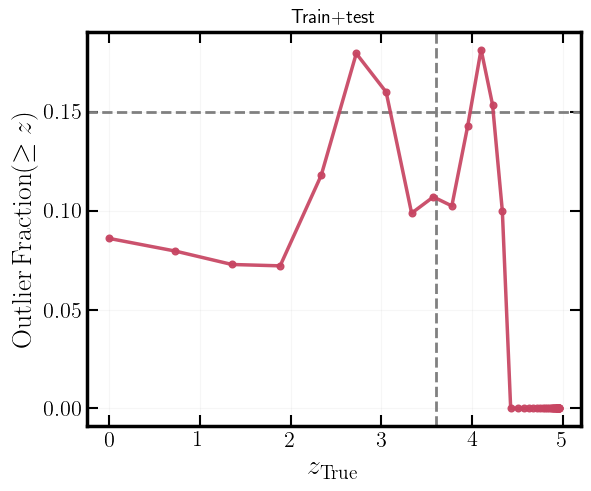

In [118]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lg_inv, out_fr_z_z_log_inv, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_inv_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()